# imports

In [1]:
!pip install einops
!pip install zarr
!pip install xarray[io]
!pip install -Uqq ipdb
from numpy import save, load
from pathlib import Path
import dask.array as da
import warnings
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import ipdb
from tqdm import tqdm
import torch
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, roc_auc_score, average_precision_score
import numpy as np
from torch import nn
import math
from torch.optim.optimizer import Optimizer
import pandas as pd
from einops import rearrange
from torch.nn import functional as F
import xarray as xr
from torch.utils.data import Dataset, DataLoader
import zarr
import sys


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 5.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 59.1 MB/s eta 0:00:00:00:010:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=61e2e9d5e02caf7322bfd9613ea88a1b2c7fcae0b29c9f385c784754cfc1a4aa
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.5 MB/s eta 0:00:00


In [2]:
%pdb off

Automatic pdb calling has been turned OFF


# support classes for model

In [3]:
#from Models.AbsolutePositionalEncoding import tAPE, AbsolutePositionalEncoding, LearnablePositionalEncoding
#from Models.Attention import Attention, Attention_Rel_Scl, Attention_Rel_Vec

def get_optimizer(name):

    if name == "Adam":
        return torch.optim.Adam
    elif name == "RAdam":
        return RAdam

def get_loss_module():
    return NoFussCrossEntropyLoss(reduction='none')  # outputs loss for each batch sample
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        # Compute the weighted BCE loss
        loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, pos_weight=self.pos_weight)
        return loss

class Permute(nn.Module):
    def forward(self, x):
        return x.permute(1, 0, 2)

# from https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam/radam.py
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])
                    p.data.copy_(p_data_fp32)

        return loss

class tAPE(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=1024).
    """

    def __init__(self, d_model, dropout=0.1, max_len=1024, scale_factor=1.0):
        super(tAPE, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)  # positional encoding
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin((position * div_term)*(d_model/max_len))
        pe[:, 1::2] = torch.cos((position * div_term)*(d_model/max_len))
        pe = scale_factor * pe.unsqueeze(0)
        self.register_buffer('pe', pe)  # this stores the variable in the state_dict (used for non-trainable variables)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe
        return self.dropout(x)

class Attention_Rel_Scl(nn.Module):
    def __init__(self, emb_size, num_heads, seq_len, dropout):
        super().__init__()
        self.seq_len = seq_len
        self.num_heads = num_heads
        self.scale = emb_size ** -0.5
        # self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)
        self.key = nn.Linear(emb_size, emb_size, bias=False)
        self.value = nn.Linear(emb_size, emb_size, bias=False)
        self.query = nn.Linear(emb_size, emb_size, bias=False)

        self.relative_bias_table = nn.Parameter(torch.zeros((2 * self.seq_len - 1), num_heads))
        coords = torch.meshgrid((torch.arange(1), torch.arange(self.seq_len)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]
        relative_coords[1] += self.seq_len - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.LayerNorm(emb_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        # k,v,q shape = (batch_size, num_heads, seq_len, d_head)

        attn = torch.matmul(q, k) * self.scale
        # attn shape (seq_len, seq_len)
        attn = nn.functional.softmax(attn, dim=-1)

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(0, self.relative_index.repeat(1, 8))
        relative_bias = rearrange(relative_bias, '(h w) c -> 1 c h w', h=1 * self.seq_len, w=1 * self.seq_len)
        attn = attn + relative_bias

        # distance_pd = pd.DataFrame(relative_bias[0,0,:,:].cpu().detach().numpy())
        # distance_pd.to_csv('scalar_position_distance.csv')

        out = torch.matmul(attn, v)
        # out.shape = (batch_size, num_heads, seq_len, d_head)
        out = out.transpose(1, 2)
        # out.shape == (batch_size, seq_len, num_heads, d_head)
        out = out.reshape(batch_size, seq_len, -1)
        # out.shape == (batch_size, seq_len, d_model)
        out = self.to_out(out)
        return out

class NoFussCrossEntropyLoss(nn.CrossEntropyLoss):
    """
    pytorch's CrossEntropyLoss is fussy: 1) needs Long (int64) targets only, and 2) only 1D.
    This function satisfies these requirements
    """

    def forward(self, inp, target):
        return F.cross_entropy(inp, target.long(), weight=self.weight,
                               ignore_index=self.ignore_index, reduction=self.reduction)

# Temporal ConvTran Model

In [13]:

class SpatioTemporalConvTran(nn.Module):
    def __init__(self, config, num_classes): # config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'
        super().__init__()
        # Parameters Initialization -----------------------------------------------
        channel_size, seq_len = config['Data_shape'][1], config['Data_shape'][2]
        temporal_channel_size = 128
        emb_size = config['emb_size']
        num_heads = config['num_heads']
        dim_ff = config['dim_ff']
        # Embedding Layer -----------------------------------------------------------
        
        #shape input: samples features timestep lat lon 
        #kernel shape depth height width
    
        self.spatial_convolution = nn.Conv3d(channel_size, temporal_channel_size, kernel_size = (1,3,3), stride=1, padding='valid')
        
        #now shape: samples outchannels timesteps 1 1
        
        #shape of their input is batch_size, feature_size, sequence_len
        
        self.input_normalization = nn.BatchNorm1d(temporal_channel_size, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.embed_layer = nn.Sequential(nn.Conv2d(1, emb_size*4, kernel_size=(1, 8), padding='same'),
                                         nn.BatchNorm2d(emb_size*4),
                                         nn.GELU())

        self.embed_layer2 = nn.Sequential(nn.Conv2d(emb_size*4, emb_size, kernel_size=[temporal_channel_size, 1], padding='valid'),
                                          nn.BatchNorm2d(emb_size),
                                          nn.GELU())

        self.Fix_Position = tAPE(emb_size, dropout=config['dropout'], max_len=seq_len)

        self.attention_layer = Attention_Rel_Scl(emb_size, num_heads, seq_len, config['dropout'])

        self.LayerNorm = nn.LayerNorm(emb_size, eps=1e-5)
        self.LayerNorm2 = nn.LayerNorm(emb_size, eps=1e-5)

        self.FeedForward = nn.Sequential(
            nn.Linear(emb_size, dim_ff),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(dim_ff, emb_size),
            nn.Dropout(config['dropout']))

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.out = nn.Linear(emb_size, num_classes)
        self.out_binary = nn.Sigmoid()



    def forward(self, x_):
        if torch.isnan(x_).any().item():
            ipdb.set_trace(context = 5)
        x = x_.squeeze()
        x = self.spatial_convolution(x)
        x = x.squeeze()
        #ipdb.set_trace()
        x = self.input_normalization(x)
        #ipdb.set_trace()
        if torch.isnan(x).any().item():
            ipdb.set_trace(context = 5)
        #ipdb.set_trace()
        x = x.unsqueeze(1) #now it is batch_size, 1, feature_size, sequence_len where the 1 is how many channels for the conv2d in first embed
        #ipdb.set_trace()
        x_src = self.embed_layer(x)
        #ipdb.set_trace()
        x_src = self.embed_layer2(x_src)
        if torch.isnan(x_src).any().item():
            ipdb.set_trace(context = 5)
        x_src = x_src.squeeze(2)
        #ipdb.set_trace()
        x_src = x_src.permute(0, 2, 1)
        #ipdb.set_trace()
        x_src_pos = self.Fix_Position(x_src)
        #ipdb.set_trace()
        att = x_src + self.attention_layer(x_src_pos)
        #ipdb.set_trace()
        att = self.LayerNorm(att)
        #ipdb.set_trace()
        out = att + self.FeedForward(att)
        #ipdb.set_trace()
        out = self.LayerNorm2(out)
        #ipdb.set_trace()
        out = out.permute(0, 2, 1)
        #ipdb.set_trace()
        out = self.gap(out)
        #ipdb.set_trace()
        out = self.flatten(out)
        #ipdb.set_trace()
        out = self.out(out)
        #ipdb.set_trace()
        out = self.out_binary(out)
        #print(torch.isnan(out).any().item())
        #ipdb.set_trace()
        if torch.isnan(out).any().item():
            ipdb.set_trace(context = 5)
        return out

# Dataset + Dataloader

In [5]:
class TemporalDatasetFromNumpy(Dataset):
    def __init__(self, numpy_array, sequence_length, radius, pin_memory, train_or_test):
        self.numpy_array = numpy_array #shape (40, 40, 918, 29), lat, lon, time, var
        self.sequence_length = sequence_length
        self.pin_memory = pin_memory
        
        self.lat_size, self.lon_size, self.time_size, self.num_variables = self.numpy_array.shape

        self.time_size -= (sequence_length) #num of timesteps with targets
        self.numpy_array = self.numpy_array[:self.time_size]
        # 40, 40, 854, 29
        # 0 to 39
        
        self.train_or_test = train_or_test
        
        self.pos_indices = np.column_stack(np.where(self.numpy_array[1:39,1:39,self.sequence_length:, -1] == 1)) 
        # shape (number_of_occurences) by (lat_indices, lon_indices, time_indices)
        self.neg_indices = np.column_stack(np.where(self.numpy_array[1:39,1:39,self.sequence_length:, -1] == 0))
            
        #ipdb.set_trace()
        self.total_indices = None
        
        if (self.train_or_test): # True -> training; False -> eval
             # 3/4 neg, 1/4 pos
            total_row_values_to_delete = None
            for index_arr in tqdm(self.pos_indices, desc = 'sampling'):
                lat = index_arr[0]
                lon = index_arr[1]
                time = index_arr[2]
                #radius = 0
                lat_range = np.arange(lat-radius, lat+radius+1) #lat is 5: np.arange(3,8) 3, 4, 5, 6, 7
                lon_range = np.arange(lon-radius, lon+radius+1)
                diameter = radius*2+1
                time_arr = np.array([time])

                grid1, grid2, grid3 = np.meshgrid(lat_range, lon_range, time_arr, indexing='ij')
                row_values_to_delete = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
                if total_row_values_to_delete is None:
                    total_row_values_to_delete = row_values_to_delete
                else:
                    total_row_values_to_delete = np.concatenate((total_row_values_to_delete, row_values_to_delete), axis=0)
                
            neg_indices_pd = pd.DataFrame(self.neg_indices)
            
            total_rows_to_delete_pd = pd.DataFrame(total_row_values_to_delete)
            n_index = neg_indices_pd.set_index([0,1,2]).index
            t_index = total_rows_to_delete_pd.set_index([0,1,2]).index
            mask = ~n_index.isin(t_index)
            result = neg_indices_pd.loc[mask]
            self.neg_indices = result.to_numpy()
            
            neg_to_pos_ratio = 2
            num_rows = len(self.pos_indices)*neg_to_pos_ratio
            random_rows = np.random.choice(self.neg_indices.shape[0], size=num_rows, replace=False)
            #ipdb.set_trace()
            neg_indices_subset = self.neg_indices[random_rows, :]
            #ipdb.set_trace()
            
            self.total_indices = np.concatenate((self.pos_indices, neg_indices_subset), axis=0)
            #self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
            
        else:
            self.total_indices = np.concatenate((self.pos_indices, self.neg_indices), axis=0)
        
        np.random.shuffle(self.total_indices)
        #ipdb.set_trace()
            
    def __len__(self): # num_samples * num_timesteps
        return len(self.total_indices)

    def __getitem__(self, index): # np array shape (40, 40, 918, 29), lat, lon, time, var
        #total indices shape (num samples) by (lat_indices, lon_indices, time_indices)
        lat_index = self.total_indices[index, 0]+1
        lon_index = self.total_indices[index, 1]+1
        time_index = self.total_indices[index, 2]

        # ex timesteps 0 to 64: 65 timesteps in total, features takes 0 to 63, target is 64th timestep
        target_np = self.numpy_array[lat_index, lon_index, time_index+sequence_length, -1] # only last variable gwis_ba
        features_np = self.numpy_array[lat_index-1:lat_index+2, lon_index-1:lon_index+2, time_index:time_index+sequence_length, : ] # all variables
        # lat, lon, time, var
        
        #target_np shape ()
        #features_np shape (64,29) lat lon time features, wants features timestep lat lon 
        #ipdb.set_trace()
        if self.pin_memory:
            target_tensor = torch.from_numpy(np.asarray(target_np)).pin_memory()
            features_tensor = torch.from_numpy(np.asarray(features_np)).pin_memory()
        else:
            target_tensor = torch.from_numpy(np.asarray(target_np))
            features_tensor = torch.from_numpy(np.asarray(features_np))
        
        target_tensor = target_tensor.float()
        features_tensor = features_tensor.float().permute(3, 2, 0, 1) #now features, time, lat, lon
        if features_tensor.shape != torch.Size([29, 64, 3, 3]):
            ipdb.set_trace(context=5)
        #if (torch.isnan(features_tensor).any().item()):
        #    ipdb.set_trace(context=5)
        #if (torch.isnan(features_tensor).any().item()):
        #    return
        
        return features_tensor, target_tensor

def temporal_dataloader(numpy_array, sequence_length, batch_size, radius, train_or_test, pin_memory=True, num_workers=0):
    temporal_dataset = TemporalDatasetFromNumpy(numpy_array, sequence_length, radius, pin_memory, train_or_test)
    dataloader = DataLoader(temporal_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return dataloader


# Trainer + Evaluator

In [6]:
# Define the training loop
def train(model, dataloader, optimizer, criterion, device, epoch_num): #each dataloader gives 1203*150 samples
    model.train()
    total_loss = 0.0
    total_samples = 0.0

    for batch_features, batch_target in tqdm(dataloader, desc = f'training epoch {epoch_num}'): #ndvi missing values
        if torch.isnan(batch_features).any().item():
            #Flatten:
            shape = batch_features.shape
            batch_features_reshaped = batch_features.reshape(shape[0],-1)
            #Drop all rows containing any nan:
            mask = ~torch.any(batch_features_reshaped.isnan(),dim=1)
            batch_features_reshaped = batch_features_reshaped[mask]
            #Reshape back:
            #ipdb.set_trace()
            batch_features = batch_features_reshaped.reshape(batch_features_reshaped.shape[0],*shape[1:])
            batch_target = batch_target[mask]

        batch_features = batch_features.to(device)
        batch_target = batch_target.squeeze().to(device)
        #ipdb.set_trace()
        # Forward pass
        outputs = model(batch_features).squeeze()
        #print(outputs, batch_target)

        if (torch.isnan(outputs).any().item()):
            ipdb.set_trace(context=5)

        loss = criterion(outputs, batch_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
        optimizer.step()
        
        num_samples = len(outputs)
        total_loss+=loss.sum()
        total_samples += num_samples
        
        #print(f'batch #{num_batches} end')
    # retrieve: model.load_state_dict(torch.load(checkpoint_path))
    return total_loss, total_samples


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_f1 = 0.0
    total_recall = 0.0
    total_precision = 0.0
    total_accuracy = 0.0
    total_aucroc = 0.0
    total_auprc = 0.0
    total_loss = 0.0
    total_loss_samples = 0.0
    total_samples = 0.0 #because each batch is the same size

    for inputs, targets in tqdm(dataloader, desc = 'evaluating'):
        with torch.no_grad():
            #ipdb.set_trace(context=5)

            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if torch.isnan(inputs).any().item():
                #Flatten:
                shape = inputs.shape
                inputs_reshaped = inputs.reshape(shape[0],-1)
                #Drop all rows containing any nan:
                mask = ~torch.any(inputs_reshaped.isnan(),dim=1)
                inputs_reshaped = inputs_reshaped[mask]
                #Reshape back:
                #ipdb.set_trace()
                inputs = inputs_reshaped.reshape(inputs_reshaped.shape[0],*shape[1:])
                targets = targets[mask]
            
            #ipdb.set_trace(context=5)
            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            
            #ipdb.set_trace(context=5)
            targets = targets.squeeze().cpu().numpy()
            predicted = torch.round(outputs).cpu().numpy()

            num_samples = len(targets)
            
            
            total_loss+=loss.sum()
            total_loss_samples += num_samples
            
            #ipdb.set_trace(context=5)
            #true, pred
            if (np.sum(targets) > 0):
                #ipdb.set_trace()
                total_f1 += f1_score(targets, predicted, pos_label=1) * num_samples
                total_precision += precision_score(targets, predicted, pos_label=1) * num_samples
                total_accuracy += accuracy_score(targets, predicted) * num_samples
                total_recall += recall_score(targets, predicted, pos_label=1) * num_samples
                total_aucroc += roc_auc_score(targets, predicted) * num_samples
                total_auprc += average_precision_score(targets, predicted) * num_samples
                total_samples += num_samples

    #average_f1 = total_f1 / total_batches
    #average_recall = total_recall / total_batches
    #average_precision = total_precision / total_batches
    #average_aucroc = total_aucroc / total_batches
    #average_accuracy = total_accuracy / total_batches
    return total_f1, total_recall, total_precision, total_auprc, total_aucroc, total_accuracy, total_samples, total_loss, total_loss_samples

# configging

In [7]:
feature_names = ['tp', 'rel_hum', 'ws10', 't2m_mean', 't2m_min', 't2m_max', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'lsm', 'drought_code_max',
                 'drought_code_mean', 'fwi_max', 'fwi_mean', 'lst_day', 'lai', 'ndvi', 'pop_dens', 'lccs_class_0', 'lccs_class_1',
                 'lccs_class_2', 'lccs_class_3', 'lccs_class_4', 'lccs_class_5', 'lccs_class_6', 'lccs_class_7', 'lccs_class_8', 'gwis_ba']
target_name = ['gwis_ba']
sequence_length = 64 # look back 512 days
config = {
    'emb_size' : 16,
    'dim_ff' : 256,
    'num_heads' : 8,
    'lr' : 1e-5,
    'dropout' : 0.01,
    'seed' : 1234,
    'Data_shape' : [4000, len(feature_names), sequence_length], #samples, features, time
    'num_labels' : 1
}

# config needs 'Data_shape', 'emb_size', 'num_heads', 'dim_ff'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#num_epochs = 20


# RUN!!!

conv tran

In [14]:
ConvTranModel = SpatioTemporalConvTran(config, num_classes=config['num_labels'])
optimizer = RAdam(ConvTranModel.parameters(), lr=config['lr'], weight_decay=0)
#pos_weight = torch.tensor([0.5]).to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.CrossEntropyLoss()
#criterion = get_loss_module()
print(sum(p.numel() for p in ConvTranModel.parameters()))

ConvTranModel.to(device)
for layer in ConvTranModel.modules():
    if isinstance(layer, nn.Module):
        layer.to(device)
        
num_epochs = 50
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

175977


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.61it/s]


epoch #0:
train_loss: 1.2635136549823365; val_loss: 1.2555451758256728!
f1: 0.5681158354363437
recall: 0.8551415361072077
precision: 0.43048161259820134
auprc: 0.418618718880108
aucroc: 0.6445440432359371
accuracy: 0.5760045489006823


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.62it/s]


epoch #1:
train_loss: 1.2483098550097218; val_loss: 1.2377528886923725!
f1: 0.575626604039818
recall: 0.831594702474498
precision: 0.44543301167445476
auprc: 0.4277454755885363
aucroc: 0.6609639677725482
accuracy: 0.6041979010494752


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.45it/s]


epoch #2:
train_loss: 1.2398690371560188; val_loss: 1.2355026293903988!
f1: 0.5883001539060846
recall: 0.7856930012805624
precision: 0.47725234744361206
auprc: 0.4506771118632614
aucroc: 0.6805954620432385
accuracy: 0.646229076546925


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.18it/s]


epoch #3:
train_loss: 1.2361938395078584; val_loss: 1.2272625835483115!
f1: 0.6063994429763733
recall: 0.7952443775134173
precision: 0.4986151855822013
auprc: 0.4688385757524032
aucroc: 0.700758968467051
accuracy: 0.6671669793621013


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.66it/s]


epoch #4:
train_loss: 1.2327450223675416; val_loss: 1.2324574634747922!
f1: 0.6102818720504608
recall: 0.7934705272005079
precision: 0.503905366392076
auprc: 0.47148322858537134
aucroc: 0.7030693666801623
accuracy: 0.6727719033232629


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.22it/s]


epoch #5:
train_loss: 1.2295788386395428; val_loss: 1.2252748462152516!
f1: 0.6070142881025558
recall: 0.8096086539047237
precision: 0.49246131766763485
auprc: 0.46544539628085435
aucroc: 0.6991884595258052
accuracy: 0.6630353117956423


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.94it/s]


epoch #6:
train_loss: 1.225701089479211; val_loss: 1.2267858960477247!
f1: 0.6252871341888645
recall: 0.8128463426868725
precision: 0.5164082276546865
auprc: 0.4838948751951474
aucroc: 0.7168189096068408
accuracy: 0.6841012084592145


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.20it/s]


epoch #7:
train_loss: 1.2189653153819318; val_loss: 1.2210558593015328!
f1: 0.622965597012949
recall: 0.7915028229304941
precision: 0.5222026233633578
auprc: 0.48611737813930334
aucroc: 0.715994965713975
accuracy: 0.6898627045326312


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.19it/s]


epoch #8:
train_loss: 1.2155228606236337; val_loss: 1.2203734292483968!
f1: 0.6323748188883695
recall: 0.7916998102539685
precision: 0.5365503633421578
auprc: 0.4971334167795965
aucroc: 0.726085723786123
accuracy: 0.7036967182195398


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.43it/s]


epoch #9:
train_loss: 1.2181375865144217; val_loss: 1.2159249507584666!
f1: 0.6342067127188137
recall: 0.77680578895679
precision: 0.5446942942327182
auprc: 0.5010351532034171
aucroc: 0.7283681151020985
accuracy: 0.7125117591721543


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.04it/s]


epoch #10:
train_loss: 1.2132192147299434; val_loss: 1.2142549564116984!
f1: 0.6183684807582285
recall: 0.720175309682905
precision: 0.5530837527201212
auprc: 0.49384875689356017
aucroc: 0.7168386294819071
accuracy: 0.7155980502437196


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.09it/s]


epoch #11:
train_loss: 1.2085551688748255; val_loss: 1.2153953559436852!
f1: 0.6319557130154632
recall: 0.7587781210109549
precision: 0.5505982441549373
auprc: 0.5015194274869126
aucroc: 0.7236093663951976
accuracy: 0.7123468426013195


evaluating: 100%|██████████| 116/116 [00:03<00:00, 38.12it/s]


epoch #12:
train_loss: 1.2093127649914899; val_loss: 1.2143659378232556!
f1: 0.6211614183755936
recall: 0.7156434541602509
precision: 0.5587537961774227
auprc: 0.5003195782769198
aucroc: 0.7176828126038227
accuracy: 0.7182621779198797


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.45it/s]


epoch #13:
train_loss: 1.208290717392627; val_loss: 1.2115438323142051!
f1: 0.6364987181011544
recall: 0.7638488277671719
precision: 0.5553379377950021
auprc: 0.5068712698023554
aucroc: 0.7311904147259992
accuracy: 0.7194731890874883


evaluating: 100%|██████████| 116/116 [00:02<00:00, 44.69it/s]


epoch #14:
train_loss: 1.205715807506678; val_loss: 1.2135875522304613!
f1: 0.631055836476955
recall: 0.7455308556966066
precision: 0.5569874660649794
auprc: 0.5034236692847751
aucroc: 0.7260935132564852
accuracy: 0.7192090395480226


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.62it/s]


epoch #15:
train_loss: 1.2080972513338415; val_loss: 1.211781586644527!
f1: 0.6247699085501066
recall: 0.7882494546039989
precision: 0.5281102621641875
auprc: 0.4906133967554869
aucroc: 0.7212081352572579
accuracy: 0.6967705595193391


evaluating: 100%|██████████| 116/116 [00:02<00:00, 44.62it/s]


epoch #16:
train_loss: 1.2063427930567394; val_loss: 1.2072824393044619!
f1: 0.632330100154224
recall: 0.7500424260047569
precision: 0.5563088052547207
auprc: 0.5029394410871991
aucroc: 0.7271989068427294
accuracy: 0.7208473940757405


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.50it/s]


epoch #17:
train_loss: 1.2017592720927759; val_loss: 1.2149118822674418!
f1: 0.6352054938185898
recall: 0.7896070040742563
precision: 0.538528390913534
auprc: 0.4975092896960599
aucroc: 0.7259024166574217
accuracy: 0.7058044999054641


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.13it/s]


epoch #18:
train_loss: 1.2037935184973825; val_loss: 1.20797626907277!
f1: 0.6311594159796872
recall: 0.7513661985003673
precision: 0.5560048942580953
auprc: 0.503636477321204
aucroc: 0.7283471827324508
accuracy: 0.7183098591549296


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.12it/s]


epoch #19:
train_loss: 1.202263869435479; val_loss: 1.211500830520676!
f1: 0.6362358953870391
recall: 0.7676241118507482
precision: 0.5513106062837878
auprc: 0.5044290571766818
aucroc: 0.7294356402750776
accuracy: 0.7167673716012085


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.96it/s]


epoch #20:
train_loss: 1.199543697419972; val_loss: 1.2060564293970615!
f1: 0.6327010064963551
recall: 0.7391963558203141
precision: 0.561784752780937
auprc: 0.5057196679543633
aucroc: 0.7264549436732719
accuracy: 0.7221179121291776


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.68it/s]


epoch #21:
train_loss: 1.1968833681651292; val_loss: 1.209102436208239!
f1: 0.6459640484014058
recall: 0.7849913564660472
precision: 0.5558279144804023
auprc: 0.5126249884390096
aucroc: 0.7356543597052723
accuracy: 0.7200830502076255


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.64it/s]


epoch #22:
train_loss: 1.200303079323995; val_loss: 1.2100301405455958!
f1: 0.6276236039500457
recall: 0.7178589431713593
precision: 0.568661359442343
auprc: 0.5059396031073123
aucroc: 0.7247082775855985
accuracy: 0.7261434217955957


evaluating: 100%|██████████| 116/116 [00:02<00:00, 39.65it/s]


epoch #23:
train_loss: 1.198085129638078; val_loss: 1.2128826309336187!
f1: 0.6183984389229116
recall: 0.7158702572558696
precision: 0.5560633637501673
auprc: 0.4962838351789082
aucroc: 0.7179875492122656
accuracy: 0.7173503951825367


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.76it/s]


epoch #24:
train_loss: 1.1962124274933188; val_loss: 1.2063522180789696!
f1: 0.6409012582020277
recall: 0.7572296112760385
precision: 0.5672170698155016
auprc: 0.5139850205222188
aucroc: 0.7347765708698764
accuracy: 0.7278206818609908


evaluating: 100%|██████████| 116/116 [00:02<00:00, 40.14it/s]


epoch #25:
train_loss: 1.1953610675188016; val_loss: 1.2097312120980632!
f1: 0.6270352805291828
recall: 0.7318773369605169
precision: 0.5616833608016222
auprc: 0.5046953092347979
aucroc: 0.7248456851999299
accuracy: 0.7224520496427228


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.96it/s]


epoch #26:
train_loss: 1.1970012333525906; val_loss: 1.2092242600476033!
f1: 0.6475330172420455
recall: 0.7333235934432454
precision: 0.5905253100773807
auprc: 0.5287789165061376
aucroc: 0.7402894950331382
accuracy: 0.7432739674118984


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.46it/s]


epoch #27:
train_loss: 1.191687414798546; val_loss: 1.2025045371917358!
f1: 0.6505058212829783
recall: 0.7699124777644588
precision: 0.5728485405218893
auprc: 0.5212020183902277
aucroc: 0.7428361900288081
accuracy: 0.7336219879518072


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.24it/s]


epoch #28:
train_loss: 1.193497082449227; val_loss: 1.2044543684662836!
f1: 0.650823136350565
recall: 0.766270768727554
precision: 0.5750746111901927
auprc: 0.5215985789362461
aucroc: 0.741394904311009
accuracy: 0.7330947447730269


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.53it/s]


epoch #29:
train_loss: 1.1938467361406602; val_loss: 1.214457968069752!
f1: 0.625131568026972
recall: 0.6592972297157038
precision: 0.6077392951220889
auprc: 0.520003992592259
aucroc: 0.7233456709783973
accuracy: 0.7442740866931667


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.21it/s]


epoch #30:
train_loss: 1.1907066744131385; val_loss: 1.2053547718603286!
f1: 0.6301723257367045
recall: 0.7024772315034966
precision: 0.585626204791691
auprc: 0.5158997066723738
aucroc: 0.730276181264168
accuracy: 0.7378403755868544


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.05it/s]


epoch #31:
train_loss: 1.193642799383466; val_loss: 1.20994211486678!
f1: 0.6372542233176449
recall: 0.7187740454422636
precision: 0.5853242242972733
auprc: 0.5186929697912739
aucroc: 0.7314203912451981
accuracy: 0.7352607709750567


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.22it/s]


epoch #32:
train_loss: 1.1954805812012077; val_loss: 1.20436621682484!
f1: 0.6483560384404053
recall: 0.732043698822368
precision: 0.5926983221085873
auprc: 0.5263104441468511
aucroc: 0.7426140257714684
accuracy: 0.7451017332328561


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.07it/s]


epoch #33:
train_loss: 1.1889057824684157; val_loss: 1.2073642149856485!
f1: 0.6252428221338892
recall: 0.637708318271419
precision: 0.6265454629116501
auprc: 0.5240771195288444
aucroc: 0.7253901475114681
accuracy: 0.7556935817805382


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.60it/s]


epoch #34:
train_loss: 1.1905802149681528; val_loss: 1.2049985880579936!
f1: 0.6499478545407188
recall: 0.7619034658010901
precision: 0.5758330072384463
auprc: 0.5225147885274644
aucroc: 0.7419018805472545
accuracy: 0.7349943374858438


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.71it/s]


epoch #35:
train_loss: 1.1912785497812481; val_loss: 1.2049631974658983!
f1: 0.6352407602464565
recall: 0.7113271318850335
precision: 0.5871792534035105
auprc: 0.5158322180338878
aucroc: 0.7304892139051457
accuracy: 0.7364063969896519


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.06it/s]


epoch #36:
train_loss: 1.1916054927351207; val_loss: 1.2050363538133597!
f1: 0.6326309149273914
recall: 0.6790176530129132
precision: 0.6071361133571158
auprc: 0.5227493012828689
aucroc: 0.7300255581486894
accuracy: 0.7471264367816092


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.03it/s]


epoch #37:
train_loss: 1.18927111632619; val_loss: 1.206513893401465!
f1: 0.646778175303765
recall: 0.7754038964714884
precision: 0.5651945040059339
auprc: 0.5164035092407868
aucroc: 0.7402318447502529
accuracy: 0.7266540642722117


evaluating: 100%|██████████| 116/116 [00:02<00:00, 39.02it/s]


epoch #38:
train_loss: 1.1862746234780106; val_loss: 1.2113222092316946!
f1: 0.6236572619568673
recall: 0.6741479753774836
precision: 0.5916414105469175
auprc: 0.5115299870515929
aucroc: 0.7225524356863309
accuracy: 0.7401396489903755


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.28it/s]


epoch #39:
train_loss: 1.1891604058278569; val_loss: 1.2084174878669507!
f1: 0.6444716728486029
recall: 0.7110308127559613
precision: 0.6016639069035306
auprc: 0.5289392679015943
aucroc: 0.7392793301352444
accuracy: 0.7515151515151515


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.90it/s]


epoch #40:
train_loss: 1.190838059536851; val_loss: 1.2007690636469508!
f1: 0.650046136593594
recall: 0.7271474911814059
precision: 0.5994862526917817
auprc: 0.5293549985288717
aucroc: 0.7431200649832151
accuracy: 0.748729531338227


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.75it/s]


epoch #41:
train_loss: 1.1898568920347388; val_loss: 1.2119922206412612!
f1: 0.6083036426104477
recall: 0.6256286061522208
precision: 0.6060075561472579
auprc: 0.509546381281773
aucroc: 0.7109573277287294
accuracy: 0.7405731523378583


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.26it/s]


epoch #42:
train_loss: 1.188351413912013; val_loss: 1.2024261670161138!
f1: 0.6489850778420302
recall: 0.7469644206463829
precision: 0.5845091925487355
auprc: 0.5260391288140525
aucroc: 0.7427704244869889
accuracy: 0.741424802110818


evaluating: 100%|██████████| 116/116 [00:02<00:00, 50.24it/s]


epoch #43:
train_loss: 1.1896099686550152; val_loss: 1.2073881774971622!
f1: 0.6477455269811798
recall: 0.7369959725080117
precision: 0.5882744793046996
auprc: 0.5247477034613957
aucroc: 0.7388990321619323
accuracy: 0.7395005675368899


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.13it/s]


epoch #44:
train_loss: 1.1870320576162967; val_loss: 1.208220144773178!
f1: 0.6387449672588936
recall: 0.7137301604168569
precision: 0.5870030474610093
auprc: 0.520513178256425
aucroc: 0.7320011170932945
accuracy: 0.7388595166163142


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.25it/s]


epoch #45:
train_loss: 1.1875539268229642; val_loss: 1.1972541543824!
f1: 0.6603179834249331
recall: 0.7317111862540467
precision: 0.6136485856526516
auprc: 0.5421560404283967
aucroc: 0.7513269386186443
accuracy: 0.7573764330013155


evaluating: 100%|██████████| 116/116 [00:02<00:00, 50.81it/s]


epoch #46:
train_loss: 1.1849726564869867; val_loss: 1.2045797941547867!
f1: 0.6477903362387255
recall: 0.7191830759072861
precision: 0.5997823576425568
auprc: 0.5308784532559873
aucroc: 0.7414407157773226
accuracy: 0.7483006042296072


evaluating: 100%|██████████| 116/116 [00:02<00:00, 50.33it/s]


epoch #47:
train_loss: 1.1876311029367057; val_loss: 1.2024088909279127!
f1: 0.6443520182817144
recall: 0.7863311640307288
precision: 0.5529912493617332
auprc: 0.5107767588347769
aucroc: 0.7367102703804758
accuracy: 0.720308676830416


evaluating: 100%|██████████| 116/116 [00:02<00:00, 50.70it/s]


epoch #48:
train_loss: 1.1843638846544715; val_loss: 1.2108878786716093!
f1: 0.6335781199958186
recall: 0.8012330929938821
precision: 0.5323410902604959
auprc: 0.49545008278673625
aucroc: 0.7253349548283738
accuracy: 0.7000377786173027


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.48it/s]

epoch #49:
train_loss: 1.183026003137885; val_loss: 1.2049122104303858!
f1: 0.6299549675287004
recall: 0.667299156739844
precision: 0.610977693881953
auprc: 0.5224252076366593
aucroc: 0.7279834964097728
accuracy: 0.7473189087488241


In [16]:
for epoch in range(50,100):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.63it/s]


epoch #50:
train_loss: 1.1875452915779063; val_loss: 1.201696809576575!
f1: 0.6576660242611729
recall: 0.7378983772102474
precision: 0.6039488707721599
auprc: 0.5367384342194612
aucroc: 0.7498330170221945
accuracy: 0.7542436816295738


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.24it/s]


epoch #51:
train_loss: 1.185729215766026; val_loss: 1.2020297336902626!
f1: 0.6567992633461521
recall: 0.7771094295906396
precision: 0.5776217968503008
auprc: 0.5282116289146264
aucroc: 0.7472117308094338
accuracy: 0.7374386097468832


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.53it/s]


epoch #52:
train_loss: 1.18985887942208; val_loss: 1.1996854745913959!
f1: 0.6367294949882878
recall: 0.6760837764889273
precision: 0.6143741735037773
auprc: 0.5287864627580149
aucroc: 0.7347058951503529
accuracy: 0.7548374976517002


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.71it/s]


epoch #53:
train_loss: 1.1849657319008993; val_loss: 1.2013691380488034!
f1: 0.6495893435650549
recall: 0.7807660280546871
precision: 0.566314857100892
auprc: 0.5183559696311814
aucroc: 0.74106898575772
accuracy: 0.727152817034106


evaluating: 100%|██████████| 116/116 [00:02<00:00, 50.38it/s]


epoch #54:
train_loss: 1.185327697568389; val_loss: 1.2000046739565668!
f1: 0.659293022067401
recall: 0.7510162362121604
precision: 0.5987873836033374
auprc: 0.5361695027152473
aucroc: 0.7500883573325167
accuracy: 0.7497644620312794


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.66it/s]


epoch #55:
train_loss: 1.1857685373942677; val_loss: 1.2025024253534191!
f1: 0.6334466209914901
recall: 0.7062068688718276
precision: 0.5873011908258735
auprc: 0.5156418549514739
aucroc: 0.7313327846475927
accuracy: 0.7399962427202705


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.62it/s]


epoch #56:
train_loss: 1.1861961320129752; val_loss: 1.2014339536136491!
f1: 0.6516352095797227
recall: 0.6971089522335804
precision: 0.6235725882536554
auprc: 0.540184810347646
aucroc: 0.7434015390860167
accuracy: 0.7581009796533534


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.32it/s]


epoch #57:
train_loss: 1.184306245058387; val_loss: 1.2029411547111741!
f1: 0.6582647216304758
recall: 0.7653969843273454
precision: 0.5881993837573193
auprc: 0.5318214572081084
aucroc: 0.7482910600719713
accuracy: 0.7418560606060606


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.00it/s]


epoch #58:
train_loss: 1.183063352048708; val_loss: 1.2002661698016657!
f1: 0.6480497746740388
recall: 0.7288233322519151
precision: 0.5977525820696723
auprc: 0.5300465236299081
aucroc: 0.7443159364164224
accuracy: 0.748541313758705


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.76it/s]


epoch #59:
train_loss: 1.184162451949374; val_loss: 1.1997222038312148!
f1: 0.6535428132051294
recall: 0.7136940844919467
precision: 0.6145198919438543
auprc: 0.5381627753296625
aucroc: 0.7451381867682604
accuracy: 0.7551789077212806


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.89it/s]


epoch #60:
train_loss: 1.1801144798230732; val_loss: 1.2060786201584508!
f1: 0.6123137290904127
recall: 0.625461539659696
precision: 0.6165122655730905
auprc: 0.5168205999085733
aucroc: 0.7154977505214831
accuracy: 0.7453521126760564


evaluating: 100%|██████████| 116/116 [00:03<00:00, 37.61it/s]


epoch #61:
train_loss: 1.1837555698339315; val_loss: 1.2062644792357036!
f1: 0.6429598294728797
recall: 0.7206923136264655
precision: 0.5920942251784359
auprc: 0.5260919696518267
aucroc: 0.7364985670930565
accuracy: 0.7420943003219087


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.55it/s]


epoch #62:
train_loss: 1.1848849780167954; val_loss: 1.200488539112599!
f1: 0.6559852015357863
recall: 0.7207896053626737
precision: 0.614838940836114
auprc: 0.5403976623624264
aucroc: 0.7469799756376772
accuracy: 0.7548095058468502


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.83it/s]


epoch #63:
train_loss: 1.184563898686451; val_loss: 1.200230524648136!
f1: 0.6525482966589154
recall: 0.7153756583783178
precision: 0.6116238598286662
auprc: 0.5354508551344298
aucroc: 0.7438068542145172
accuracy: 0.7544718508755414


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.82it/s]


epoch #64:
train_loss: 1.1792351126446883; val_loss: 1.2073927181075537!
f1: 0.6291214775412005
recall: 0.6734721162326026
precision: 0.6037943840483454
auprc: 0.5203489804382085
aucroc: 0.7276856470324873
accuracy: 0.7457563183704262


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.54it/s]


epoch #65:
train_loss: 1.1832985004802121; val_loss: 1.2048925965855388!
f1: 0.645215346679432
recall: 0.7016000602448618
precision: 0.6095376815466029
auprc: 0.5306079123488434
aucroc: 0.7388110274894083
accuracy: 0.7517958412098299


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.96it/s]


epoch #66:
train_loss: 1.1834616488504348; val_loss: 1.2077123662911775!
f1: 0.648007365032092
recall: 0.7297449745028078
precision: 0.5957335731393241
auprc: 0.528242014066601
aucroc: 0.7419561809840496
accuracy: 0.7451722832260508


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.69it/s]


epoch #67:
train_loss: 1.1780142878487563; val_loss: 1.2139673169946608!
f1: 0.6108081154631743
recall: 0.664696712982584
precision: 0.5776657239299674
auprc: 0.502765861847375
aucroc: 0.7130146082659637
accuracy: 0.7306747306747307


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.21it/s]


epoch #68:
train_loss: 1.1798796630622574; val_loss: 1.1998659831582272!
f1: 0.6276020312027104
recall: 0.7019219828755634
precision: 0.5796510837945013
auprc: 0.5115127916553948
aucroc: 0.7283132450705062
accuracy: 0.736989891426432


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.69it/s]


epoch #69:
train_loss: 1.1842544655091043; val_loss: 1.2137982849786264!
f1: 0.5870670939882084
recall: 0.5940327651868145
precision: 0.5959165476466014
auprc: 0.4947348007470409
aucroc: 0.6978029077576032
accuracy: 0.7331830139045472


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.16it/s]


epoch #70:
train_loss: 1.1792066869992717; val_loss: 1.2063425965306458!
f1: 0.6110893177186045
recall: 0.641938349721659
precision: 0.5975348223051268
auprc: 0.5076263854287528
aucroc: 0.7132710112597638
accuracy: 0.7373756335648582


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.09it/s]


epoch #71:
train_loss: 1.1788200761021164; val_loss: 1.203948524633743!
f1: 0.6465092704763221
recall: 0.7001424465770593
precision: 0.6143531421636534
auprc: 0.5338338921312021
aucroc: 0.7420210816922954
accuracy: 0.7546313799621929


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.93it/s]


epoch #72:
train_loss: 1.1815601596205263; val_loss: 1.216355894270637!
f1: 0.5818431870786238
recall: 0.5773416260594609
precision: 0.6100839802527402
auprc: 0.5021871573382919
aucroc: 0.6980408925096223
accuracy: 0.7367131549189597


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.64it/s]


epoch #73:
train_loss: 1.178543127802351; val_loss: 1.2023434743944026!
f1: 0.6412283602207647
recall: 0.745354118138109
precision: 0.5750981830865305
auprc: 0.5153593127281558
aucroc: 0.7352953425465458
accuracy: 0.7324553151458137


evaluating: 100%|██████████| 116/116 [00:02<00:00, 44.79it/s]


epoch #74:
train_loss: 1.1831125091257528; val_loss: 1.2019298726372956!
f1: 0.6325931720018652
recall: 0.710777216423678
precision: 0.5847585565676972
auprc: 0.5157146928898292
aucroc: 0.7320105583743215
accuracy: 0.7381982320857626


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.98it/s]


epoch #75:
train_loss: 1.1794422906660385; val_loss: 1.2125375487913845!
f1: 0.6059445459706724
recall: 0.6774991600198363
precision: 0.5639578033887803
auprc: 0.4936674486156621
aucroc: 0.7088259627206963
accuracy: 0.7172686230248307


evaluating: 100%|██████████| 116/116 [00:02<00:00, 39.66it/s]


epoch #76:
train_loss: 1.1775964223732873; val_loss: 1.2141827704099717!
f1: 0.6128075473491378
recall: 0.6479656113765196
precision: 0.5943781437974067
auprc: 0.5113628656085377
aucroc: 0.7135132960268957
accuracy: 0.7353497164461248


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.22it/s]


epoch #77:
train_loss: 1.17772431039709; val_loss: 1.2040916388313887!
f1: 0.6306843257489643
recall: 0.6644595563592102
precision: 0.6096758418762972
auprc: 0.5216688650888477
aucroc: 0.7252710825610739
accuracy: 0.7468949943545352


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.76it/s]


epoch #78:
train_loss: 1.1797631914659001; val_loss: 1.2008842359515661!
f1: 0.6313279122712114
recall: 0.6748881210507526
precision: 0.6041515709044237
auprc: 0.5213673629411483
aucroc: 0.7304254555357114
accuracy: 0.7507501875468867


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.98it/s]


epoch #79:
train_loss: 1.1801565253387616; val_loss: 1.2031111278515993!
f1: 0.6327180407734786
recall: 0.6896586858265379
precision: 0.5973581638358498
auprc: 0.5198309360412599
aucroc: 0.7304663956721018
accuracy: 0.7444967074317969


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.77it/s]


epoch #80:
train_loss: 1.1798892362377653; val_loss: 1.2041657155690386!
f1: 0.6367686775780974
recall: 0.7085506190092645
precision: 0.5907453733743521
auprc: 0.5210084426705702
aucroc: 0.7333498211032762
accuracy: 0.7417530631479736


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.95it/s]


epoch #81:
train_loss: 1.1762672199296031; val_loss: 1.2055997272801837!
f1: 0.60932503658035
recall: 0.6345192221103757
precision: 0.5979779410767312
auprc: 0.5062571817282912
aucroc: 0.7133649368677715
accuracy: 0.7420322459692539


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.40it/s]


epoch #82:
train_loss: 1.1771498830305145; val_loss: 1.2013668928554593!
f1: 0.6414746995915199
recall: 0.6615693093552167
precision: 0.638411583361872
auprc: 0.5403031148612204
aucroc: 0.7392698559379168
accuracy: 0.7648500848576277


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.11it/s]


epoch #83:
train_loss: 1.1778534434012387; val_loss: 1.1993335479409415!
f1: 0.6461512325296984
recall: 0.7146698098983464
precision: 0.5996458013483721
auprc: 0.527056241400107
aucroc: 0.7398080374145858
accuracy: 0.7483555722608533


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.26it/s]


epoch #84:
train_loss: 1.1810390596455973; val_loss: 1.2012426098962237!
f1: 0.6204582165891717
recall: 0.6498928576002464
precision: 0.611706311252981
auprc: 0.5165803316472282
aucroc: 0.7231763432400815
accuracy: 0.7488755622188905


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.14it/s]


epoch #85:
train_loss: 1.1823643615603678; val_loss: 1.2228821171815634!
f1: 0.6016243486800906
recall: 0.632270606539469
precision: 0.5863628979494993
auprc: 0.501613811080174
aucroc: 0.7044561813202395
accuracy: 0.7298632218844985


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.14it/s]


epoch #86:
train_loss: 1.1798136613496746; val_loss: 1.211494549367223!
f1: 0.6154031028575723
recall: 0.6603049691248211
precision: 0.5893715370699192
auprc: 0.5072626449517497
aucroc: 0.7159774913605935
accuracy: 0.7337858220211161


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.95it/s]


epoch #87:
train_loss: 1.1772123476026357; val_loss: 1.213671543712307!
f1: 0.6065551994729084
recall: 0.6611468856486395
precision: 0.5755399656284761
auprc: 0.4960321695368046
aucroc: 0.7084989081762516
accuracy: 0.7237090086694309


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.03it/s]


epoch #88:
train_loss: 1.1816963606632187; val_loss: 1.2032865394082897!
f1: 0.62487406795221
recall: 0.6894118531880518
precision: 0.5810332582462926
auprc: 0.5083000567240394
aucroc: 0.7224066636654981
accuracy: 0.7355588897224306


evaluating: 100%|██████████| 116/116 [00:02<00:00, 39.51it/s]


epoch #89:
train_loss: 1.1781014171555813; val_loss: 1.2082028297987908!
f1: 0.6292168766076606
recall: 0.6628547817379862
precision: 0.6114977646518737
auprc: 0.5253358039946852
aucroc: 0.7261876248872329
accuracy: 0.748535802002645


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.61it/s]


epoch #90:
train_loss: 1.1791318573220804; val_loss: 1.2042903400388785!
f1: 0.6374252927271565
recall: 0.6997399286922378
precision: 0.5957688751807754
auprc: 0.5237884166835816
aucroc: 0.732558318925983
accuracy: 0.7436380772855796


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.33it/s]


epoch #91:
train_loss: 1.1791047347390353; val_loss: 1.19738941590514!
f1: 0.6474280850277394
recall: 0.7389818677283029
precision: 0.5831498959252852
auprc: 0.5232215073240616
aucroc: 0.7393440290550225
accuracy: 0.7414019921067468


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.46it/s]


epoch #92:
train_loss: 1.17787569220471; val_loss: 1.205768893420002!
f1: 0.6256876210809966
recall: 0.7092447818483024
precision: 0.5695219585430368
auprc: 0.5056323982576525
aucroc: 0.7221033019437615
accuracy: 0.7269823374671176


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.57it/s]


epoch #93:
train_loss: 1.1781103002082194; val_loss: 1.2035461807034356!
f1: 0.6572888618485029
recall: 0.7298217040758099
precision: 0.6102897412731324
auprc: 0.5399144733302002
aucroc: 0.7488257378228168
accuracy: 0.7539276925989021


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.35it/s]


epoch #94:
train_loss: 1.1777208552811342; val_loss: 1.2030538018873471!
f1: 0.6370090120940607
recall: 0.6722003797057422
precision: 0.6193480517376249
auprc: 0.5292652843725595
aucroc: 0.7331372785228564
accuracy: 0.7525870178739417


evaluating: 100%|██████████| 116/116 [00:02<00:00, 45.96it/s]


epoch #95:
train_loss: 1.1786650906105571; val_loss: 1.1957124290976275!
f1: 0.663505045084544
recall: 0.769896827908939
precision: 0.5909751022416752
auprc: 0.5344930103658503
aucroc: 0.7523254015828348
accuracy: 0.7478817548484278


evaluating: 100%|██████████| 116/116 [00:02<00:00, 49.28it/s]


epoch #96:
train_loss: 1.178145846298039; val_loss: 1.2169073734626301!
f1: 0.5992805141109253
recall: 0.585094899239464
precision: 0.6293121375578079
auprc: 0.5130044324902983
aucroc: 0.7054157766827621
accuracy: 0.7464522232734153


evaluating: 100%|██████████| 116/116 [00:02<00:00, 46.74it/s]


epoch #97:
train_loss: 1.1761865281873176; val_loss: 1.2032098382908405!
f1: 0.6482054624746226
recall: 0.7345508266177847
precision: 0.5906860158632204
auprc: 0.5258777610872881
aucroc: 0.74121394627944
accuracy: 0.7440982058545798


evaluating: 100%|██████████| 116/116 [00:02<00:00, 47.36it/s]


epoch #98:
train_loss: 1.178945483597457; val_loss: 1.2116215908689196!
f1: 0.6067507446192059
recall: 0.6320792797114173
precision: 0.5977691344604796
auprc: 0.5076899105122866
aucroc: 0.7115794742021194
accuracy: 0.7383107088989442


evaluating: 100%|██████████| 116/116 [00:02<00:00, 48.23it/s]

epoch #99:
train_loss: 1.177560463359451; val_loss: 1.2035602531526444!
f1: 0.6306645118473377
recall: 0.6628419307003045
precision: 0.6192378251503993
auprc: 0.5242500698848755
aucroc: 0.7291973798440163
accuracy: 0.7507999247129682


In [ ]:
for epoch in range(100,150):
    batch_size = 50
    file_path = Path('/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy')
    train_numpy_array = np.load(file_path)[:,:,:700,:]
    train_dataloader = temporal_dataloader(train_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    loss, samples = train(ConvTranModel, train_dataloader, optimizer, criterion, device, epoch)
    del train_numpy_array
    del train_dataloader
    #checkpoint_path = f'/kaggle/output/model_checkpoints/model_checkpoint_epoch_{epoch}.pt'
    #torch.save(ConvTranModel.state_dict(), checkpoint_path)
    train_losses.append(loss.item()/samples)
    
    batch_size = 50
    val_numpy_array = np.load(file_path)[:,:,700:,:]
    val_dataloader = temporal_dataloader(val_numpy_array, sequence_length, batch_size, radius = 0, train_or_test = True, pin_memory = False, num_workers=0)
    f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, val_dataloader, criterion, device)
    del val_numpy_array
    del val_dataloader
    
    val_losses.append(loss.item()/loss_samples)
    
    print(f'epoch #{epoch}:')
    print(f'train_loss: {train_losses[epoch]}; val_loss: {val_losses[epoch]}!')
    print(f'f1: {f1/samples}')
    print(f'recall: {recall/samples}')
    print(f'precision: {precision/samples}')
    print(f'auprc: {auprc/samples}')
    print(f'aucroc: {aucroc/samples}')
    print(f'accuracy: {accuracy/samples}')

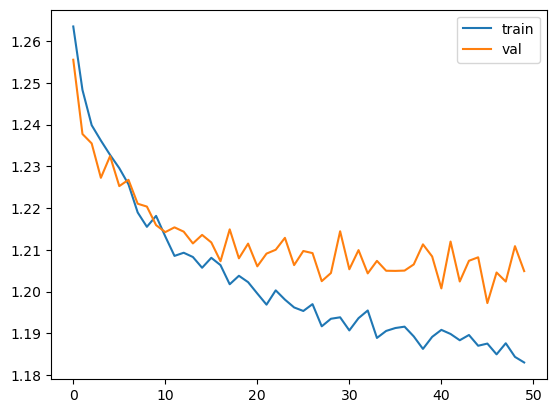

In [15]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()
plt.show()

In [ ]:
batch_size = 50
file_path = Path("/kaggle/input/california-spatial-temporal-fire-dataset/numpy_california_spatialtemporal_dataset.npy")
numpy_array = np.load(file_path)[:,:,700:,:]
dataloader = temporal_dataloader(numpy_array, sequence_length, batch_size, radius = 2, train_or_test = False, pin_memory = False, num_workers=0)
f1, recall, precision, auprc, aucroc, accuracy, samples, loss, loss_samples = evaluate_model(ConvTranModel, dataloader, criterion, device)
del numpy_array
del dataloader

print(f'epoch #{epoch}:')
print(f'val_loss: {loss/loss_samples}!')
print(f'f1: {f1/samples}')
print(f'recall: {recall/samples}')
print(f'precision: {precision/samples}')
print(f'auprc: {auprc/samples}')
print(f'aucroc: {aucroc/samples}')
print(f'accuracy: {accuracy/samples}')